<a href="https://colab.research.google.com/github/Kheil-Z/MAPI3_Tutorial/blob/main/Answers_MAPI3_AutoEncoder_Latent_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning and AutoEncoders.
The goal of this notebook is to understand and handle AutoEncoders using Pytorch.

It is recommended to run the notebook on Colab over a GPU device ([how to use a GPU on colab ](https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html)).

Author: K. Ziad

Inspired by : https://deeplearning.neuromatch.io/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial1.html

## Guidelines :
Carefuly read the given code then
*   complete cells marked with a TODO.
*   answer questions marked with a QUESTION .



In [ ]:
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
seed = 42

# Set numpy seed
np.random.seed(seed)

# Set torch seeds
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda:0


# 1) The dataset

We are going to apply our AutoEncoder to the MNIST dataset, we can start by downloading it from Pytorch.

In [ ]:
#### Downloading dataset and creating Torch Dataloaders:

# Download the MNIST Dataset
train_dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = transforms.ToTensor())
val_dataset = datasets.MNIST(root = "./data",
                         train = False,
                         download = True,
                         transform = transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The following list will be useful for plotting specific digits (see 3) Generative Models).

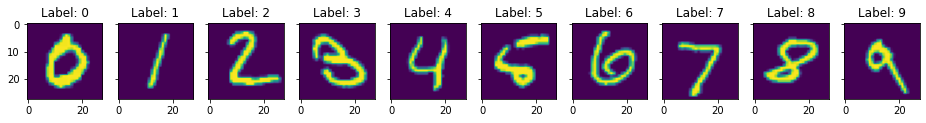

In [ ]:
all_digits_idx = []
for digit in range(10):
  idx_image = 0
  while val_dataset[idx_image][1] != digit :
    idx_image+=1
  all_digits_idx.append(idx_image)

fig,axs = plt.subplots(1,10, sharey=True, figsize=(16,8))
for i,idx in enumerate(all_digits_idx):
  axs[i].imshow(val_dataset[idx][0].view(28,28))
  axs[i].set_title(f"Label: {val_dataset[idx][1]}")

Note that for the rest of this notebook, we will be exploring the realm of Unsupervized Learning approaches. Althugh MNIST is a dataset comrpised of images as well as lassociated labels, we will intentionally disregard the labels, and focus solely on the pixel information. 

With this in mind, the goal of the notebook is to explore how we can work with only pixel values. Several possibilities arise, we focus on AutoEncoders and the concept of *Latent Spaces*. 

Without loss of generality, an AutoEncoder is comprised of **encoder**, a **bottleneck** and a **decoder** :
*  The encoder maps data from a high-dimensional input to the bottleneck where the sub-space is the smallest.
* The decoder converst the encoded input back to the original input space.
* The space of the bottleneck is what we commonly refer to as the **latent space**. It is usually much smaller than the input space, but more informative. It can be seen as a compressed version of the image space in our case. Usually AutoEncoders look something like this:

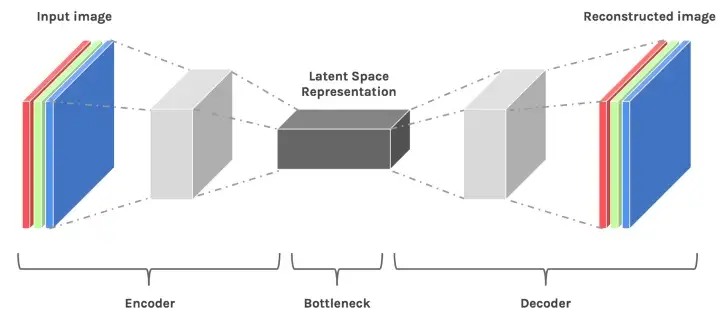


(Image from [this article](https://medium.com/hackernoon/latent-space-visualization-deep-learning-bits-2-bd09a46920df))

Thoughouth the notebook, ty to have a look at this figure and identify the different components of our networks.


## 1.1) Helper Functions

Take time to understand and complete the following helper functions. What do they do?

In [ ]:
def train_autoencoder(autoencoder, train_dataset, val_dataset, batch_size, device, epochs=20, lr=1e-3, weight_decay=1e-5):
  """
  Function to train a given autoencoder

  Input:
    autoencoder: a torch Autoencoder 
    train_dataset: Torch dataset containing training samples.
    val_dataset: Torch dataset containing validation samples.
    batch_size: Batch size to construct dataloaders.
    device: Device to run model on.
    epochs: Number of epochs [default: 20]
    lr: Learning rate for ADAM optimizer [default: 1e-3]
    weight_decay: Weight decay factor for ADAM optimizer [default: 1e-5]

  Returns:
    loss_train: List of losses over each epoch during training phase.
    loss_val: List of losses over each epoch during validation phase.
  """
  # Set model to device, construct dataloaders and optimizer
  autoencoder.to(device)
  optimizer = torch.optim.Adam(autoencoder.parameters(),
                           lr=lr,
                           weight_decay=weight_decay)
  criterion = nn.MSELoss()
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = batch_size,
                                     shuffle = True)
  val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                     batch_size = batch_size,
                                     shuffle = False)
  # Initialize empty loss lists
  loss_train, loss_val = [],[]

  # Run training loop
  for epoch in tqdm(range(epochs), desc='Epoch'):
    ####### Train loop #######
    autoencoder.train()
    running_loss = 0.0
    for image, _ in train_loader:
      # ===================forward=====================
      image = image.to(device)
      reconstructed_image = autoencoder(image)
      loss = criterion(reconstructed_image.view(batch_size, -1), image.view(batch_size, -1))
      # ===================backward====================
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Log the batch loss
      running_loss += loss.detach() * image.size(0)
    # Append the epoch's loss:
    loss_train.append(running_loss.cpu()/len(train_dataset))

    ####### Val loop #######
    autoencoder.eval()
    running_loss = 0.0
    for image, _ in val_loader:
      ### TODO: Complete the validation loop of the function ####
      # ===================forward=====================
      image = image.to(device)
      reconstructed_image = autoencoder(image)
      loss = criterion(reconstructed_image.view(batch_size, -1), image.view(batch_size, -1))

      # Log the batch loss
      running_loss += loss.detach() * image.size(0)
    # Append the epoch's loss:
    loss_val.append(running_loss.cpu()/len(val_dataset))

  autoencoder.to('cpu')
  return loss_train, loss_val

In [ ]:
def plot_samples(autoencoder, dataset, num_to_plot=10):
  fig, axs = plt.subplots(2,10, figsize=(80,10))
  for i in range(num_to_plot):
    sample = dataset[np.random.randint(len(dataset))][0].view(-1,1,28,28)
    reconstruction = autoencoder(sample)

    axs[0][i].imshow(sample.view(28, 28))
    axs[1][i].imshow(reconstruction.detach().view(28, 28))
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()
  return None

1.2) Setting Hyper-parameters

In [ ]:
# Hyper-parameters for all of our models. You may change this at will after running the notebook

latent_dim = 20 # Size of our latent dimension
batch_size = 64 
num_epochs = 15
learning_rate = 1e-3
weight_decay_value = 1e-5

# 2) The Models

We can begin by simply implementing a Linear AutoEncoder. It is composed of two fully connected layers, one for encoding our input and one for decoding our latent space.

 In order to ensure strict linearity for now, no activation functions are used.

## 2.1) Linear AutoEncoder

In [ ]:
class LinearAutoEncoder(nn.Module):
  def __init__(self, latent_dim):
    super(LinearAutoEncoder, self).__init__()

    # Encoder layer (a linear mapping from input size to hidden_dimension)
    self.linear_encoder = nn.Linear(28 * 28, latent_dim)

    # Decoder layer (a linear mapping from hidden_dimension to input size)
    self.linear_decoder = nn.Linear(latent_dim, 28 * 28)

  def encode(self, x):
    # Encode the input sample
    latent = self.linear_encoder(x.view(x.size(0), -1))
    return latent

  def decode(self, latent):
    # Decode the latent vector
    x_prime = self.linear_decoder(latent).view(-1,1,28,28)
    return x_prime

  def forward(self, x):
    latent = self.encode(x)
    return self.decode(latent)

In [ ]:
# Construct AE
linear_ae = LinearAutoEncoder(latent_dim)

summary(linear_ae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]          15,700
            Linear-2                  [-1, 784]          16,464
Total params: 32,164
Trainable params: 32,164
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


Total number of trainable parameters in model : 32164


Epoch: 100%|██████████| 15/15 [02:00<00:00,  8.03s/it]


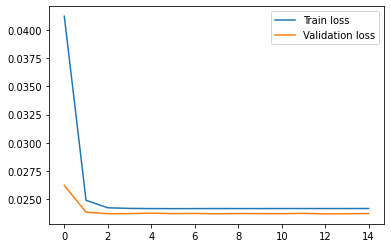

In [ ]:
##### Train model:

### TODO:  Train the AE using the previously defined hyper-parameters ###
linear_ae_loss_train, linear_ae_loss_val = train_autoencoder(linear_ae, train_dataset, val_dataset, batch_size, device, epochs=num_epochs, lr=learning_rate, weight_decay=weight_decay_value)

### TODO: Plot the Reconstruction train and validation losses of the Linear AE ###
plt.plot(linear_ae_loss_train, label="Train loss")
plt.plot(linear_ae_loss_val, label="Validation loss")
plt.legend()


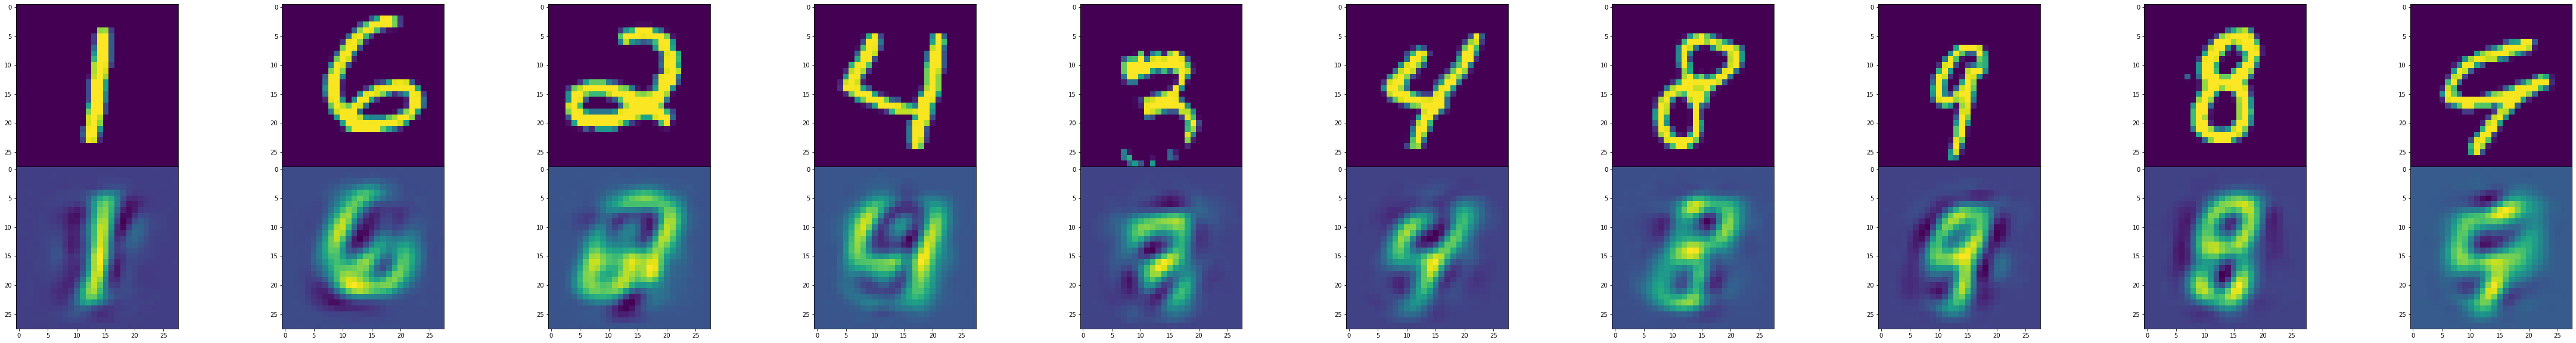

In [ ]:
# Plot some reconstructions:
plot_samples(linear_ae, val_dataset, num_to_plot=10)

#### QUESTION
 What do you think of these sample reconstructions? What easy steps could you implement in order to obtain more accurate reconstructions?

TODO: They are not visually pleasing or accurate, but are still impressive for such a basic model. The model can clearly differentiate between digits, but inter-digit variation seems to be blurry. We could add more layers to the encoder and decoder , but activation functions would then be necessary and thus the model would not be linear strictly speaking. Furthermore, an output activation could help force the network to at least get the correct intensity range. ???



---


#### QUESTION
 In terms of dimensionality-reduction abilities, how do you think such a model compares to other algorithms you may have seen such as PCA?

TODO: A strictly linear auto-encoder has an analogous setup to the PCA problem, hence both will project the image onto the same linear sub-space ???

## 2.1) Convolutional AutoEncoder (Non Linear)

In order to implement a Convolutional AutoEncoder, we will be using Transpose Convolutions in order to upsample our latent space.

#### QUESTION

 Using [Pytorch's documentation](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) and [this explanation](https://d2l.ai/chapter_computer-vision/transposed-conv.html), explain in your own words how a Transpose convolution works. Does it correspond to a "deconvolution" in the sens of the inverse of the convolution operator?

TODO: The Transpose Covolution is not strictly speaking a "deconvolution", instead it upsamples inputs by applying a strided convolution, and summing the resulting outputting. It still contains a trainable kernel, which makes it more reliable than simply using a linear interpolation of values to upsample our images. ???

The following is an example implementation of a Convolutional AE using pytorch. It takes an MNIST image (1,28,28) image, convolves it to a (64,1,1) feature map

*   It takes an MNIST image (1,28,28) image,
*   Convolves it to a (64,1,1) feature map,
*   Flattens the feature map, into a vector of shape 64,
*   Reduces this to the given latent_dimension size,
*   Then decodes the latent vector back to an image.

Complete the class implementation in order to have an AE which functions as aforementioned. (You may want to use [Pytroch's documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for a refresher on convolutional arithmetic).


In [ ]:
class ConvAutoEncoder(nn.Module):
    def __init__(self,latent_dim):
        super(ConvAutoEncoder, self).__init__()
        # Input (batch_size, 1, 28, 28)
        self.encoder = nn.Sequential(
            ### TODO: Complete the missing values ###
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # (batch_size, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (batch_size, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # (batch_size, 64, 1, 1)
            nn.ReLU(),
            nn.Flatten()
            )
        
        ### TODO: Complete the missing values ###
        self.fc_encoder = nn.Linear(64, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, 64)
        
        
        #64, 1, 1
        self.decoder = nn.Sequential(
            ### TODO: Complete the missing values ###
            nn.Unflatten(dim=-1, unflattened_size=(64,1,1)),
            nn.ConvTranspose2d(64, 32, 7), # (batch_size, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # (batch_size, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # (batch_size,1, 28, 28)
            nn.Sigmoid()
            )
        
    def encode(self, x):
        ### TODO: Complete the encode method ###
        x = self.encoder(x)
        latent = self.fc_encoder(x)
        return latent

    def decode(self, latent):
      ### TODO: Complete the decode method ###
        s = F.relu(self.fc_decoder(latent))
        x_prime = self.decoder(s)
        return x_prime

    def forward(self, x):
        latent = self.encode(x)
        x_prime = self.decode(latent)
        return x_prime

#### QUESTION
 Why is the final activation of our network a Sigmoid? What other activation functions could we have used?

TODO : The value range of the MNIST pixels in ur case have been scaled to the range [0,1], hence we need an activation which will constrain output values to this range, the Sigmoid/Logistic activation is perfect for this. ???

In [ ]:
# Construct AE
conv_ae = ConvAutoEncoder(latent_dim)

summary(conv_ae, (1, 28, 28))

Total number of trainable parameters in model : 213013


Epoch: 100%|██████████| 15/15 [02:56<00:00, 11.79s/it]


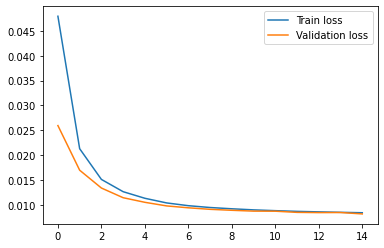

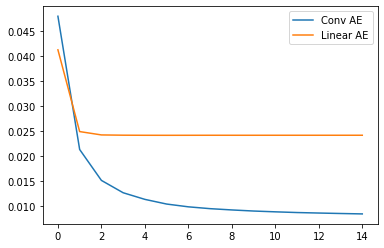

In [ ]:
##### Train model:

### TODO:  Train the AE using the previously defined hyper-parameters ###
conv_ae_loss_train, conv_ae_loss_val = train_autoencoder(conv_ae, train_dataset, val_dataset, batch_size, device, epochs=num_epochs, lr=learning_rate, weight_decay=weight_decay_value)

### TODO: Plot the Reconstruction train and validation losses of the Convolutional AE ###
plt.plot(conv_ae_loss_train, label="Train loss")
plt.plot(conv_ae_loss_val, label="Validation loss")
plt.legend()
plt.show()

### TODO: Plot the Reconstruction losses of both models ###
plt.plot(conv_ae_loss_train, label="Conv AE")
plt.plot(linear_ae_loss_train, label="Linear AE")
plt.legend()
plt.show()

#### QUESTION
 Which of both models performs better? Why do you think that is?

TODO : Based on the final loss values, for the same bottleneck size, the Convolutional AE clearly outperforms the Linear AE. This can be expected as the second model can modle non-linear relaions between input and output. Furthermore the Convolutional approach is *usually* more appropriate in the compute vision domain than fully connected layers, this is a result of several intrinsic properties of CNN's.

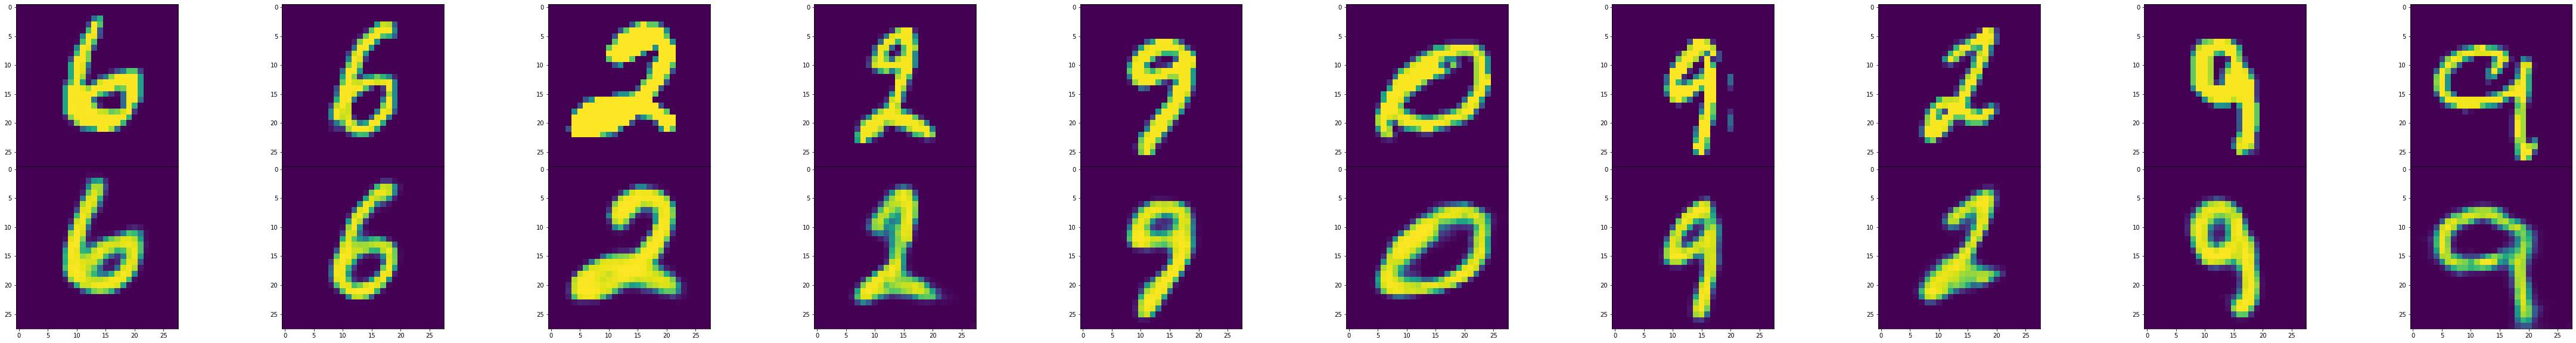

In [ ]:
# Plot some reconstructions:
plot_samples(conv_ae, val_dataset, num_to_plot=10)

## 2.1) Variational AutoEncoder (VAEs)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Input: (batch_size, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), #(batch_size, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), #(batch_size, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), #(batch_size, 64, 1, 1)
            nn.ReLU(),
            nn.Flatten()
            )
        
        
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        self.fc_decoder = nn.Linear(latent_dim, 64)
        
        
        # Input: (batch_size, 64, 1, 1)
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(64,1,1)),
            nn.ConvTranspose2d(64, 32, 7), #(batch_size, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), #(batch_size, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), #(batch_size, 1, 28, 28)
            nn.Sigmoid()
            )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mu + (std * epsilon)
        return z

    
    def encode(self, x):
        x = self.encoder(x)

        # Get mu and logvar or reparam trick
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        latent = self.reparameterize(mu, logvar)
        return latent, mu, logvar

    def decode(self, latent):
        s = F.relu(self.fc_decoder(latent))
        x_prime = self.decoder(s)
        return x_prime


    def forward(self, x):
        latent, mu, logvar = self.encode(x)
       
        x_prime = self.decode(latent)
        return x_prime, mu, logvar

The following is a re-implementation of the train function for the VAE.

In [ ]:

def VAE_loss_fn(mse_loss, mu, logvar, beta=1):
    KL_Div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + beta*KL_Div



def train_VAE(vae, train_dataset, val_dataset, batch_size, device, epochs=20, lr=1e-3, weight_decay=1e-5, beta=1):
  """
    Function to train a given autoencoder

    Input:
      vae: a VAE model 
      train_dataset: Torch dataset containing training samples.
      val_dataset: Torch dataset containing validation samples.
      batch_size: Batch size to construct dataloaders.
      device: Device to run model on.
      epochs: Number of epochs [default: 20]
      lr: Learning rate for ADAM optimizer [default: 1e-3]
      weight_decay: Weight decay factor for ADAM optimizer [default: 1e-5]
      beta: weight of Kullback-Leibler divergence in VAE loss function

    Returns:
      loss_train: List of losses over each epoch during training phase.
      loss_val: List of losses over each epoch during validation phase.
      mse_loss_train
      mse_loss_val
  """
  # Set model to device, construct dataloaders and optimizer
  vae.to(device)
  optimizer = torch.optim.Adam(vae.parameters(),
                           lr=lr,
                           weight_decay=weight_decay)
  MSE_criterion = nn.MSELoss(reduction='sum')
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = batch_size,
                                     shuffle = True)
  val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                     batch_size = batch_size,
                                     shuffle = False)
  # Initialize empty loss lists
  loss_train, loss_val = [],[]
  mse_loss_train, mse_loss_val = [],[]
  # Run training loop
  for epoch in tqdm(range(epochs), desc='Epoch'):
    ####### Train loop #######
    vae.train()
    running_loss, running_loss_mse = 0.0, 0.0
    for image, _ in train_loader:
        # ===================forward=====================
      image = image.to(device)
      reconstruction, mu, logvar  = vae(image)
      # Compute loss elements :
      mse_loss = MSE_criterion(reconstruction.view(batch_size, -1), image.view(batch_size, -1))
      loss = VAE_loss_fn(mse_loss, mu, logvar, beta=beta)
      # ===================backward====================
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Log the batch loss
      running_loss += loss.detach() * image.size(0)
      running_loss_mse += mse_loss.detach() * image.size(0)
    # Append the epoch's loss:
    loss_train.append(running_loss.cpu()/len(train_dataset))
    mse_loss_train.append(running_loss_mse.cpu()/len(train_dataset))

    ####### Val loop #######
    vae.eval()
    running_loss, running_loss_mse = 0.0, 0.0
    for image, _ in val_loader:
      # ===================forward=====================
      image = image.to(device)
      reconstruction, mu, logvar  = vae(image)
      # Compute loss elements :
      mse_loss = MSE_criterion(reconstruction.view(batch_size, -1), image.view(batch_size, -1))
      loss = VAE_loss_fn(mse_loss, mu, logvar, beta=beta)

      # Log the batch loss
      running_loss += loss.detach() * image.size(0)
      running_loss_mse += mse_loss.detach() * image.size(0)
    # Append the epoch's loss:
    loss_val.append(running_loss.cpu()/len(val_dataset))
    mse_loss_val.append(running_loss_mse.cpu()/len(val_dataset))

  vae.to('cpu')
  return loss_train, loss_val, mse_loss_train, mse_loss_val

In [ ]:
# Construct AE
vae_model = VAE(latent_dim)

summary(vae_model, (1, 28, 28))

Total number of trainable parameters in model : 214313


Epoch: 100%|██████████| 15/15 [03:17<00:00, 13.19s/it]


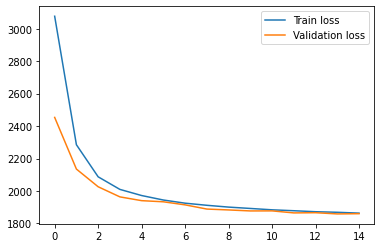

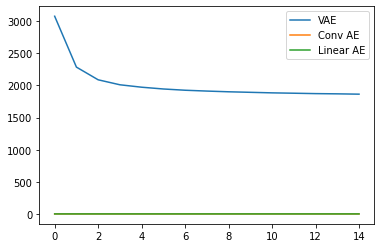

In [ ]:
#### Train VAE

### TODO:  Train the VAE using the previously defined hyper-parameters ###
vae_loss_train, vae_loss_val, vae_loss_train_mse, vae_loss_val_mse = train_VAE(vae_model, train_dataset, val_dataset, batch_size, device, epochs=15, lr=1e-3, weight_decay=1e-5)

### TODO: Plot the Reconstruction train and validation losses of the Convolutional AE ###
plt.plot(vae_loss_train, label="Train loss")
plt.plot(vae_loss_val, label="Validation loss")
plt.legend()
plt.show()

### TODO: Plot the Reconstruction losses of all three models ###
plt.plot(vae_loss_train, label="VAE")
plt.plot(conv_ae_loss_train, label="Conv AE")
plt.plot(linear_ae_loss_train, label="Linear AE")
plt.legend()
plt.show()



---

#### QUESTION
 Why does the plotted Loss seem to indicate that the VAE has a terrible reconstruction compared to the previous models? Is it the case?

TODO: The loss function we are optimiwing is not the same anymore! The reconstruction loss for a VAE contains two terms, the reconstruction error (MSE, BCE, etc..) and the Kullback-Leibler Divergence term to "organize" our latent space.

 Furthemore, the MSE used here has a reduction="sum" parameter, which means we our loss over all of the pixels, contrary to the default mean reduction which we were using previously.
 
 Note that the reason we are summing, is because the reconstruction error is the "*expected log-likelihood of the data given the latent variables*" and not the average log-likelihood:
 $$ \mathbb{E}_{q_\phi} [ log(p_\theta(x \lvert z)) ]$$ 
  ???

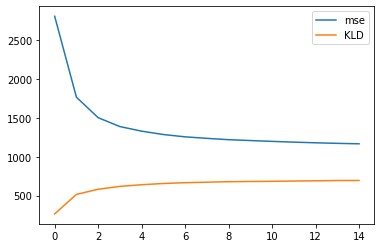

In [ ]:
### TODO: Plot the VAE's training MSE and KLD loss seperately. Recall that VAE_loss = mse_loss + KL_Div (if you kept beta=1) ###
plt.plot(vae_loss_train_mse, label="mse")
plt.plot([vae_loss_train[i] - vae_loss_train_mse[i] for i in range(len(vae_loss_train_mse)) ], label="KLD")
plt.legend()

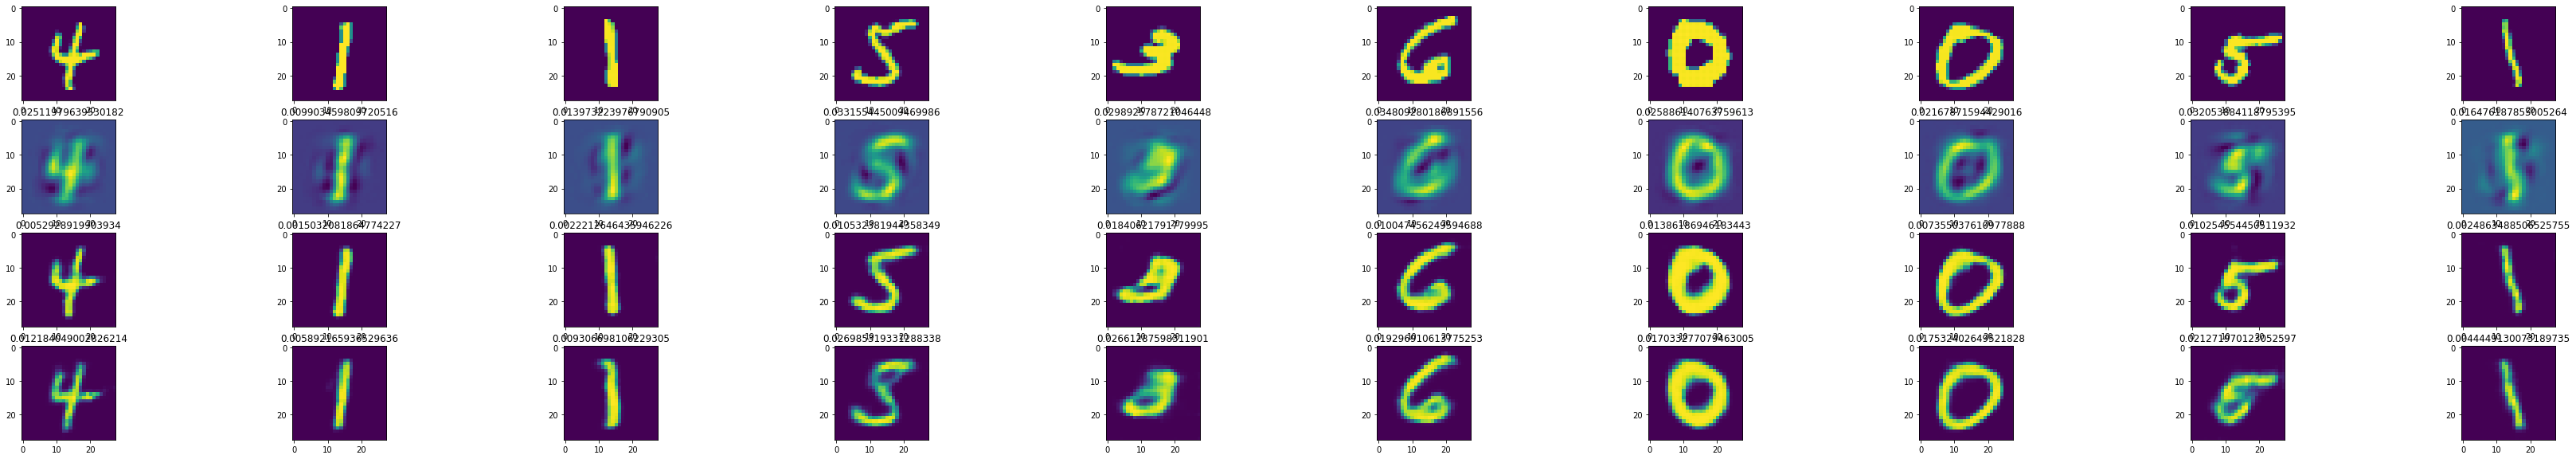

In [ ]:
### TODO: Read the plot_samples helper function again, and complete the script in order to compare sample reconstructions from all three trained models  ###

fig, axs = plt.subplots(4,10, figsize=(60,10))
criterion = nn.MSELoss()
for i in range(10):
  # Get a random sample from the MNIST validation set.
  sample = val_dataset[np.random.randint(len(val_dataset))][0].view(-1,1,28,28)

  # Forward through trained models to get reconstructions.
  reconstruction_linear_ae = linear_ae(sample) # TODO
  reconstruction_conv_ae = conv_ae(sample) # TODO
  reconstruction_vae, _, _ = vae_model(sample) # TODO

  # Evaluate the reconstruction error.
  lin_ae_mse = criterion(reconstruction_linear_ae,sample).item() # TODO
  conv_ae_mse = criterion(reconstruction_conv_ae,sample).item() # TODO
  vae_mse = criterion(reconstruction_vae,sample).item() # TODO

  # Display everything
  axs[0][i].imshow(sample.view(28, 28))
  axs[1][i].imshow(reconstruction_linear_ae.detach().view(28, 28))
  axs[1][i].set_title(str(lin_ae_mse))
  axs[2][i].imshow(reconstruction_conv_ae.detach().view(28, 28))
  axs[2][i].set_title(str(conv_ae_mse))
  axs[3][i].imshow(reconstruction_vae.detach().view(28, 28))
  axs[3][i].set_title(str(vae_mse))
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# As Generative Models:

AutoEncoders are not only useful for dimensionality-reduction. They also encapsulate generating capabilities, and sometimes display interesting properties in terms of their Latent Space.

#### QUESTION
 What does the following function do?

TODO : Given two sample images and an autoencoder, **interpolate(ae, x_1, x_2)** will generate reconstructioned images along a linear interpolation of the latent space between the images x_1 and x_2 ???

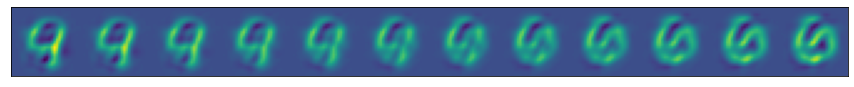

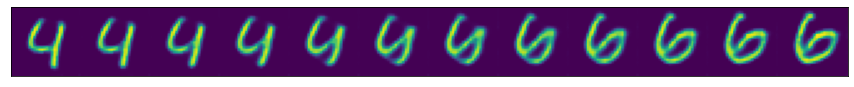

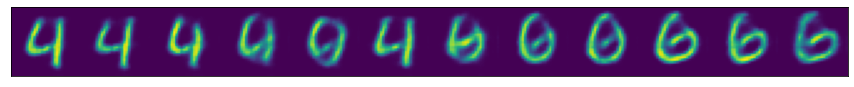

In [ ]:
def interpolate(ae, x_1, x_2, n=12):
    if not isinstance(ae,VAE):
      z_1 = ae.encode(x_1.view(-1,1,28,28))
      z_2 = ae.encode(x_2.view(-1,1,28,28))
    else:
      z_1, mu_1, logvar_1 = ae.encode(x_1.view(-1,1,28,28))
      z_2, mu_2, logvar_2 = ae.encode(x_2.view(-1,1,28,28))
    image = np.zeros((28,28*n))
    for i, t in enumerate(np.linspace(0, 1, n)):
      if not isinstance(ae,VAE):
        recons = ae.decode(z_1 + (z_2 - z_1)*t).view(28,28).detach().numpy()
      else:
        mu = mu_1 + (mu_2 - mu_1)*t
        logvar = logvar_1 + (logvar_2 - logvar_1)*t
        latent = ae.reparameterize(mu, logvar)
        recons = ae.decode(latent).detach().numpy()
      image[:, 28*i:28*(i+1)] = recons
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()

idx_1, idx_2 = all_digits_idx[4], all_digits_idx[6]
img_1, img_2 = val_dataset[idx_1][0], val_dataset[idx_2][0]

interpolate(linear_ae, img_1, img_2)
interpolate(conv_ae, img_1, img_2)
interpolate(vae_model, img_1, img_2)

# interpolate(model,image[0,:,:,:],image[3,:,:,:])
# interpolate(model,image[3,:,:,:],image[2,:,:,:])

#### QUESTION
 What can you say abouth the latent spaces of these models?

TODO : ??? A linear interpolation in the latent space between the encoding of the two images does not seem to signify much for the strictly linear AE, it fails to produce an organized latent space.

On the other hand, between two points in the latent space corresponding to actual inputs from the dataset, both the convolutional autoencoder and the VAe have a seemingly structured latent sub-space.



---

#### QUESTION
 What does the following function do?

TODO : Given an autoencoder model, it will generate samples by randomly sampling the latent space of the model, and simply trying to decode this random vector. We may notice that for the VAE, we are using the reparametrization trick to sample a latent vector given a specific distribution. ???

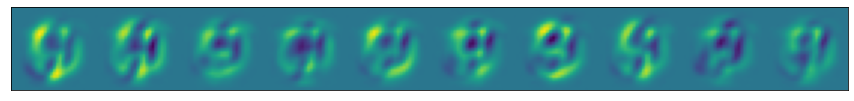

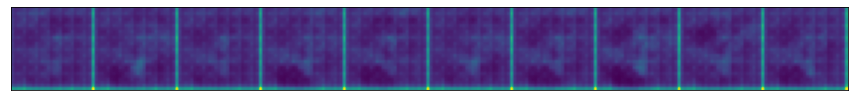

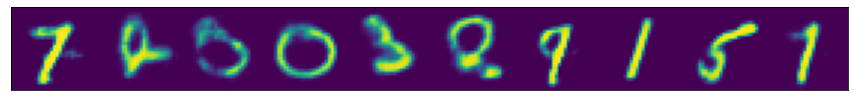

In [ ]:
def generate(ae, n=10):
  images = np.zeros((28,28*n))
  for i in range(n):
    if not isinstance(ae,VAE):
      latent = torch.rand(1,latent_dim)
      image = ae.decode(latent).view(1, 28,28).detach().numpy()
    else:
      mu = torch.zeros(1, latent_dim)
      logvar = torch.ones(1, latent_dim)
      latent = ae.reparameterize(mu, logvar)
      image = ae.decode(latent).view(1, 28,28).detach().numpy()
    images[:, 28*i:28*(i+1)] = image[0]
  plt.figure(figsize=(15,10))
  plt.imshow(images)
  plt.xticks([])
  plt.yticks([])

generate(linear_ae)
generate(conv_ae)
generate(vae_model)

TODO : ??? Samples generated from by the VAE are more realistic (i.e look more like the training distribution) than those generated by the AutoEncoders.

The previous analysis now breaks down and we can clearly see the purpose of the VAE. 

While an AE simply compresses and reconstructs a training sample, a VAE parametrizes  the underlying distribution of the dataset. Thus their latent space is, by construction, more coherent than an AutoEncoder, and sampling any point from the latent space yields a seemingly plausible reconstruction.



---




# Bonus:

Using the [Scikit-Learn's documentation on T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), further inspect the latent dimension of our three models.

(If you want to read more on T-SNE and latent spaces : 
* [nice notebook](https://notebook.community/nikbearbrown/Deep_Learning/NEU/Nik_Bear_Brown_DL/Latent_Space_Visualization/NBB_Latent_Space_Visualization)
* [Video on Latent spaces](https://www.youtube.com/watch?v=7Pcvdo4EJeo)

)

In [ ]:
# TODO : using T-SNE embedding, visualize the latent space of all three models sparetely on a 2-D plot.


from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sn


def plot_latent_TSNE(ae, dataset):
  # Get all dataset samples in a torch tensor
  all_data_val = dataset.data
  # encode the samples to get the latent space
  latent_data = ae.encode(all_data_val)
  # Initialize a t-sne projection
  tsne_model = TSNE(n_components=2, random_state=0), TSNE(n_components=2, random_state=0), TSNE(n_components=2, random_state=0)
  # Apply it
  projected_data = tsne_model.fit_transform(latent_data.detach().numpy())

  #### Plot
  tsne_data = np.vstack(projected_data.T, dataset.targets.numpy()).T
  df = pd.DataFrame(data = tsne_data, columns=("X", "Y", "labels"))

  sn.FacetGrid(df, hue="labels", size=8).map(plt.scatter, "X", "Y").add_legend()

  return tsne_model, df

plot_latent_TSNE(linear_ae, val_dataset)
plot_latent_TSNE(conv_ae, val_dataset)
plot_latent_TSNE(vae_model, val_dataset)